In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import RobustScaler
from colorama import Fore
from sklearn import metrics
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, f1_score, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA 
import math
warnings.filterwarnings('ignore')

# Load dataset

In [2]:
df = pd.read_csv("..\clean data\clean_data_train.csv")
data = df.drop(["Name", "Address"], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011 entries, 0 to 1010
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Price                1011 non-null   int64  
 1   Size                 1011 non-null   int64  
 2   Distance to beach    1011 non-null   float64
 3   Distance to airport  1011 non-null   float64
 4   Pool                 1011 non-null   int64  
 5   Car                  1011 non-null   int64  
 6   Non-smoking room     1011 non-null   int64  
 7   Near beach           1011 non-null   int64  
 8   WiFi                 1011 non-null   int64  
 9   Family room          1011 non-null   int64  
 10  Bar                  1011 non-null   int64  
 11  Breakfast            1011 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 94.9 KB


## Phân chia train set và validation set

In [3]:
X = data.drop(["Price"] , axis=1)
y = data["Price"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0)
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)

### Hàm này dùng để đánh giá mô hình

### Sử dụng 3 metrics: MAE, RMSE và MAPE để nhanh chóng đánh giá sơ bộ kết quả của mô hình

In [4]:
def models_score(x_train, x_val, y_train, y_val):    
    models = {
        "Linear": LinearRegression(),
        "RandomForest":RandomForestRegressor(),
         }
    evalutes = {}
    i = 0
    maes = []
    rmse = []
    mape = []
    names = []
    for name, model in models.items():
        model.fit(x_train, y_train)
        y_pred=model.predict(x_val) 
        names.append(name)
        maes.append(mean_absolute_error(y_val,y_pred))
        rmse.append(math.sqrt(mean_squared_error(y_val,y_pred)))
        mape.append(mean_absolute_percentage_error(y_val, y_pred))
    evalutes = {'Algorithms': names, 'MAE': maes, 'RMSE': rmse, "MAPE":mape}
    model_scores = pd.DataFrame(evalutes)
    return model_scores

## Feature Extraction

### Khảo sát hiệu suất mô hình trước khi thực hiện trích xuất đặc trưng

In [5]:
score = models_score(X_train, X_val, y_train, y_val)
score

,Algorithms,MAE,RMSE,MAPE
0,Linear,602.329064,1013.410572,0.686749
1,RandomForest,482.955218,978.089160,0.410884


### Sử dụng PCA để giảm chiều dữ liệu

In [6]:
scores = []
for i in range(1, 12):
  pca = PCA(n_components=i)
  pca.fit(X_train)
  X_train_pca = pca.transform(X_train)
  X_val_pca = pca.transform(X_val)
  scores.append(models_score(X_train_pca, X_val_pca, y_train, y_val))

best_score = scores[4] #kết quả tốt nhất khi n_components = 5
best_score

,Algorithms,MAE,RMSE,MAPE
0,Linear,593.749632,1013.652110,0.665944
1,RandomForest,454.496073,1048.705321,0.389915


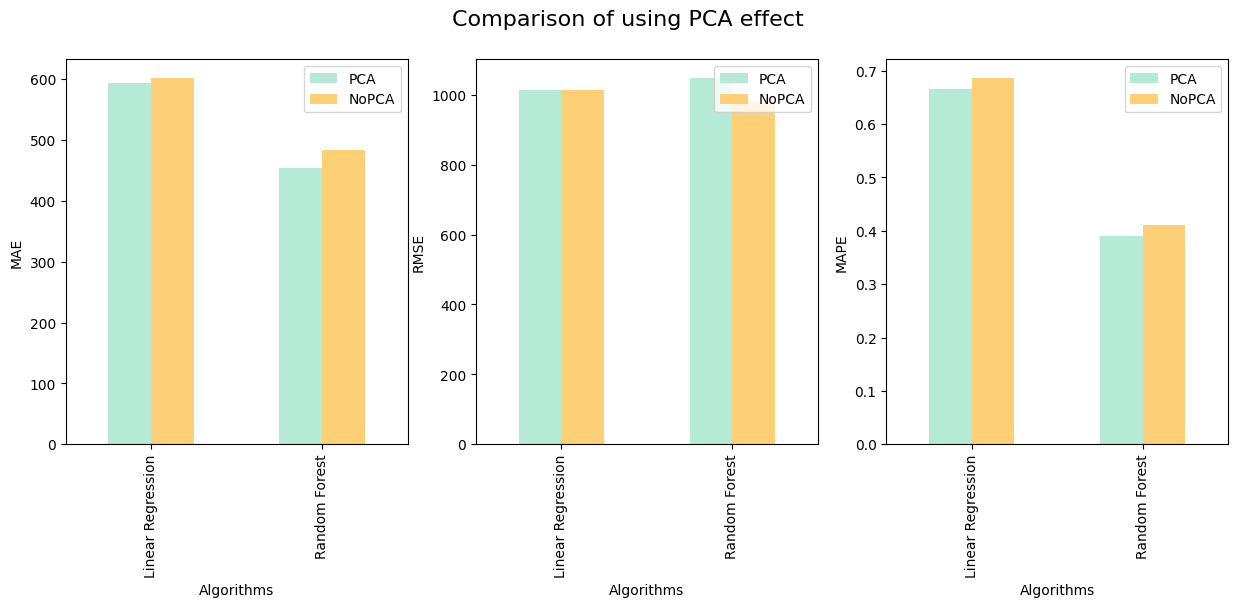

In [7]:
metrics = ["MAE", "RMSE", "MAPE"]
fig, axs = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Comparison of using PCA effect', fontsize=16) 
for i in range(len(metrics)):
    df_comparea_pca = pd.DataFrame({
        'Algorithms': ["Linear Regression", "Random Forest"],
        'PCA': [best_score[metrics[i]][0], best_score[metrics[i]][1]],
        'NoPCA': [score[metrics[i]][0], score[metrics[i]][1]],
    })
    df_comparea_pca.plot(x="Algorithms", y=["PCA", "NoPCA"], kind="bar", ax = axs[i], color=['#b5ead7', '#fdcf76']
)
    axs[i].set_ylabel(metrics[i])

=> PCA không cải thiện nhiều hiệu suất mô hình, vậy nên chúng ta không áp dụng PCA

### Tạo thêm các biến mới
- Ở đây, chúng ta sẽ tạo thêm 2 biến mới:
    - Ratio: tỉ lệ giữa khoảng cách từ khách sạn đến biển và khoảng cách từ khách sạn đến sân bay
    - Facilities: số lượng các dịch vụ được ưa chuộng nhất mà khách sạn cung cấp
- Dựa trên kết quả EDA, chúng ta sẽ muốn Ratio sẽ có mối quan hệ nghịch biến với Price
- Theo thường thức, Facilities nên có quan hệ đồng biến với Price

In [8]:
def create_new_feature(X):
    tmp = X.copy()
    facs = [ "Pool", "Bar",'Car','Non-smoking room','WiFi','Family room','Breakfast', "Near beach"]
    tmp["Facilities"] = X[facs].sum(axis =1)
    tmp["Ratio"] = X["Distance to beach"] / X["Distance to airport"]
    return tmp

In [9]:
tmp_data = create_new_feature(data)
tmp_data.corr()

,Price,Size,Distance to beach,Distance to airport,Pool,Car,Non-smoking room,Near beach,WiFi,Family room,Bar,Breakfast,Facilities,Ratio
Price,1.000000,0.830076,-0.164909,0.384179,0.306330,0.104705,-0.034993,0.058262,0.049186,-0.038160,0.227594,-0.032213,0.194401,-0.051582
Size,0.830076,1.000000,-0.105079,0.296037,0.216788,0.035101,-0.076284,0.030093,0.022754,-0.070643,0.105783,-0.046014,0.079618,-0.039015
Distance to beach,-0.164909,-0.105079,1.000000,-0.477759,-0.181876,-0.152920,0.046326,-0.430387,-0.013939,-0.038621,-0.096419,-0.034004,-0.257528,0.323886
Distance to airport,0.384179,0.296037,-0.477759,1.000000,0.227717,0.121489,-0.008528,0.248651,0.008730,-0.033619,0.188360,0.016225,0.224411,-0.247859
Pool,0.306330,0.216788,-0.181876,0.227717,1.000000,0.222374,0.057487,0.115377,0.120663,0.101077,0.393270,0.087355,0.580799,-0.088610
Car,0.104705,0.035101,-0.152920,0.121489,0.222374,1.000000,0.227672,0.157294,0.095995,0.255461,0.204670,0.074634,0.610568,-0.088180
Non-smoking room,-0.034993,-0.076284,0.046326,-0.008528,0.057487,0.227672,1.000000,0.033653,0.114418,0.364817,0.203763,0.052209,0.505911,-0.050499
Near beach,0.058262,0.030093,-0.430387,0.248651,0.115377,0.157294,0.033653,1.000000,-0.008765,0.169506,0.103311,0.047622,0.455447,-0.096217
WiFi,0.049186,0.022754,-0.013939,0.008730,0.120663,0.095995,0.114418,-0.008765,1.000000,0.072881,0.117530,0.045750,0.320179,-0.112549
Family room,-0.038160,-0.070643,-0.038621,-0.033619,0.101077,0.255461,0.364817,0.169506,0.072881,1.000000,0.184681,0.056472,0.559172,0.002064


- Từ bảng tương quan ta có thể thấy các dự đoán của chúng ta là tương đối chính xác

### Thêm 2 đặc trưng mới vào tập train và val

In [10]:

X_train = create_new_feature(X_train)
X_val = create_new_feature(X_val)

## Feature Selection

### Đối vói mô hình Linear Regression

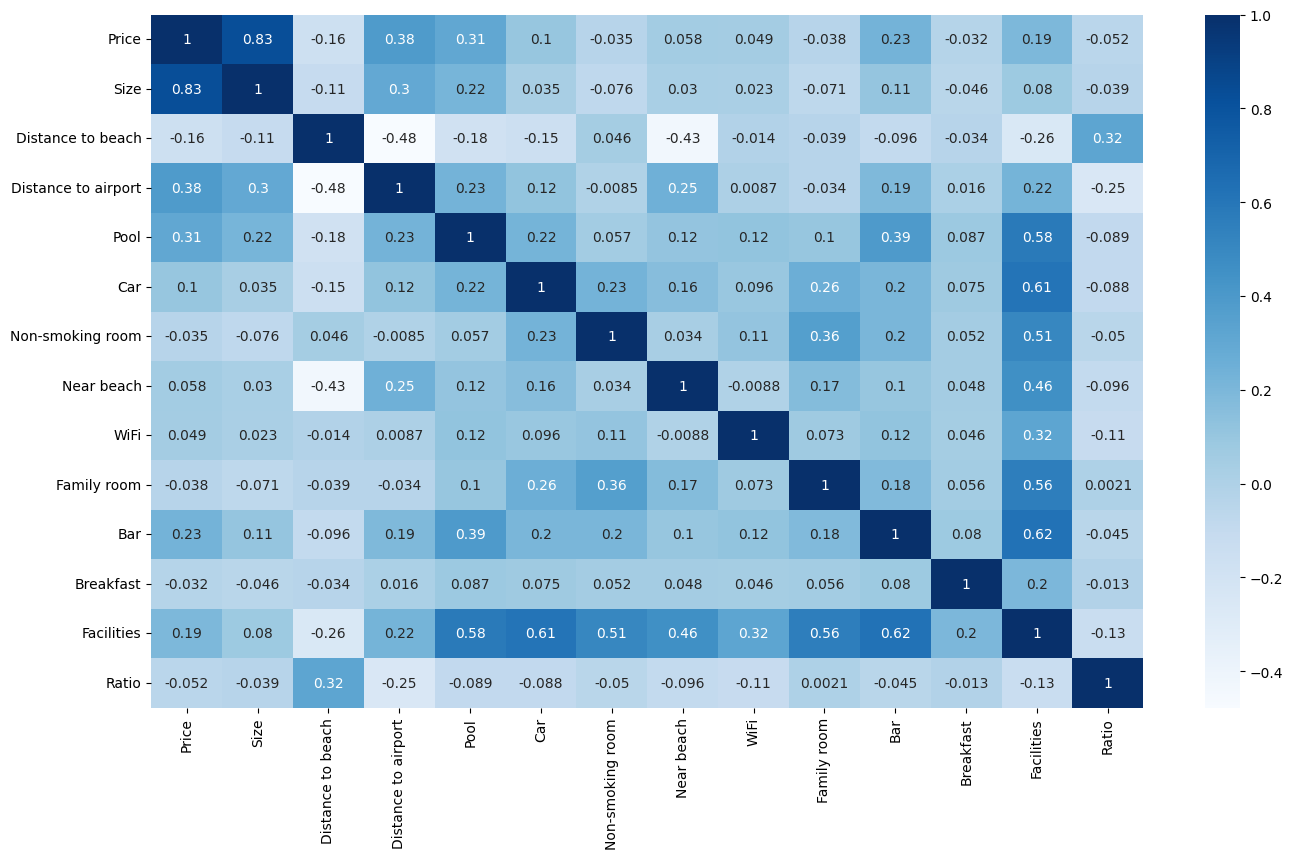

In [11]:
plt.figure(figsize = (16, 9))
dataplot = sns.heatmap(tmp_data.corr(), annot = True, cmap= "Blues")

### Từ correlation map, ta thấy top 4 các đặc trưng quan trọng cho mô hình Linear Regression là: 
- Size
- Distance to beach
- Distance to airport
- Facilities

### Đối với mô hình Random Forest


Feature: 0, Score: 0.75025
Feature: 1, Score: 0.06274
Feature: 2, Score: 0.07258
Feature: 3, Score: 0.00787
Feature: 4, Score: 0.00716
Feature: 5, Score: 0.00703
Feature: 6, Score: 0.00641
Feature: 7, Score: 0.00146
Feature: 8, Score: 0.00340
Feature: 9, Score: 0.00641
Feature: 10, Score: 0.00008
Feature: 11, Score: 0.02067
Feature: 12, Score: 0.05396


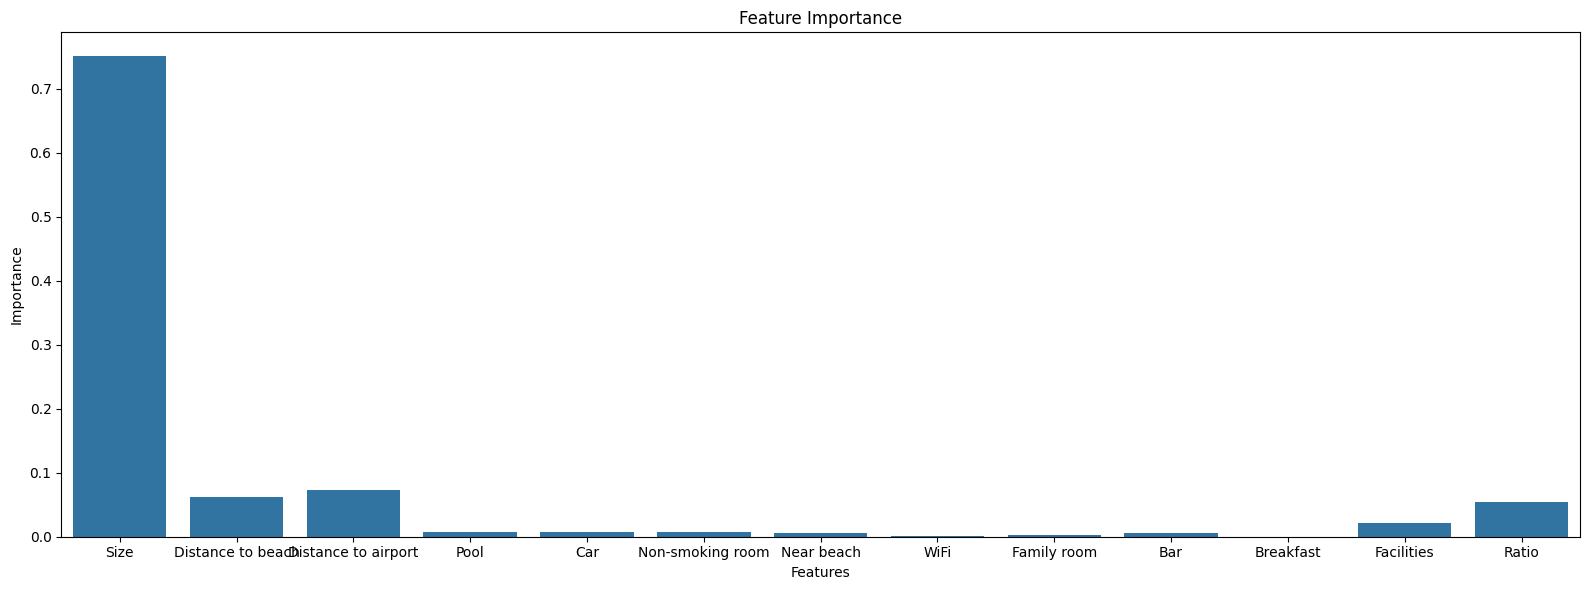

In [12]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

plt.figure(figsize=(16, 6)) 
sns.barplot(x=list(X_train.columns), y=importance)


plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance")

plt.tight_layout()
plt.show()

### Từ đây, ta thấy được top 5 feature cho mô hình random forest là: 
 - Size
 - Distance to beach
 - Distance to airport
 - Facilities
 - Ratio

### Ngoài ra, từ kết quả EDA, ta thấy 2 biến Pool và Bar cũng có ảnh hưởng đến biến mục tiêu, vậy nên ta sẽ chọn thêm 1 biến Pool và Bar
=> Như vậy, 2 mô hình của chúng ta sẽ có 7 features:
- Size
- Distance to beach
- Distance to airport
- Pool
- Bar
- Facilities
- Ratio

### Chọn ra những feature quan trọng

In [13]:
selected_features = ["Size", "Distance to beach", "Distance to airport", "Pool", "Bar", "Facilities", "Ratio"]
X_train = X_train[selected_features]
X_val = X_val[selected_features]
X_train

,Size,Distance to beach,Distance to airport,Pool,Bar,Facilities,Ratio
0,22,0.85,4.1,1,0,4,0.207317
1,25,0.30,4.5,0,0,5,0.066667
2,28,0.20,4.3,0,1,6,0.046512
3,35,0.20,4.8,1,0,6,0.041667
4,18,0.25,4.4,0,0,3,0.056818
...,...,...,...,...,...,...,...
702,68,0.10,4.4,1,0,3,0.022727
703,22,2.40,2.6,0,0,4,0.923077
704,25,0.25,4.5,0,0,4,0.055556
705,25,0.45,4.1,0,1,3,0.109756


## Feature Transformation

### Dữ liệu trước khi scale

Text(0.5, 0, 'Distance to airport (km)')

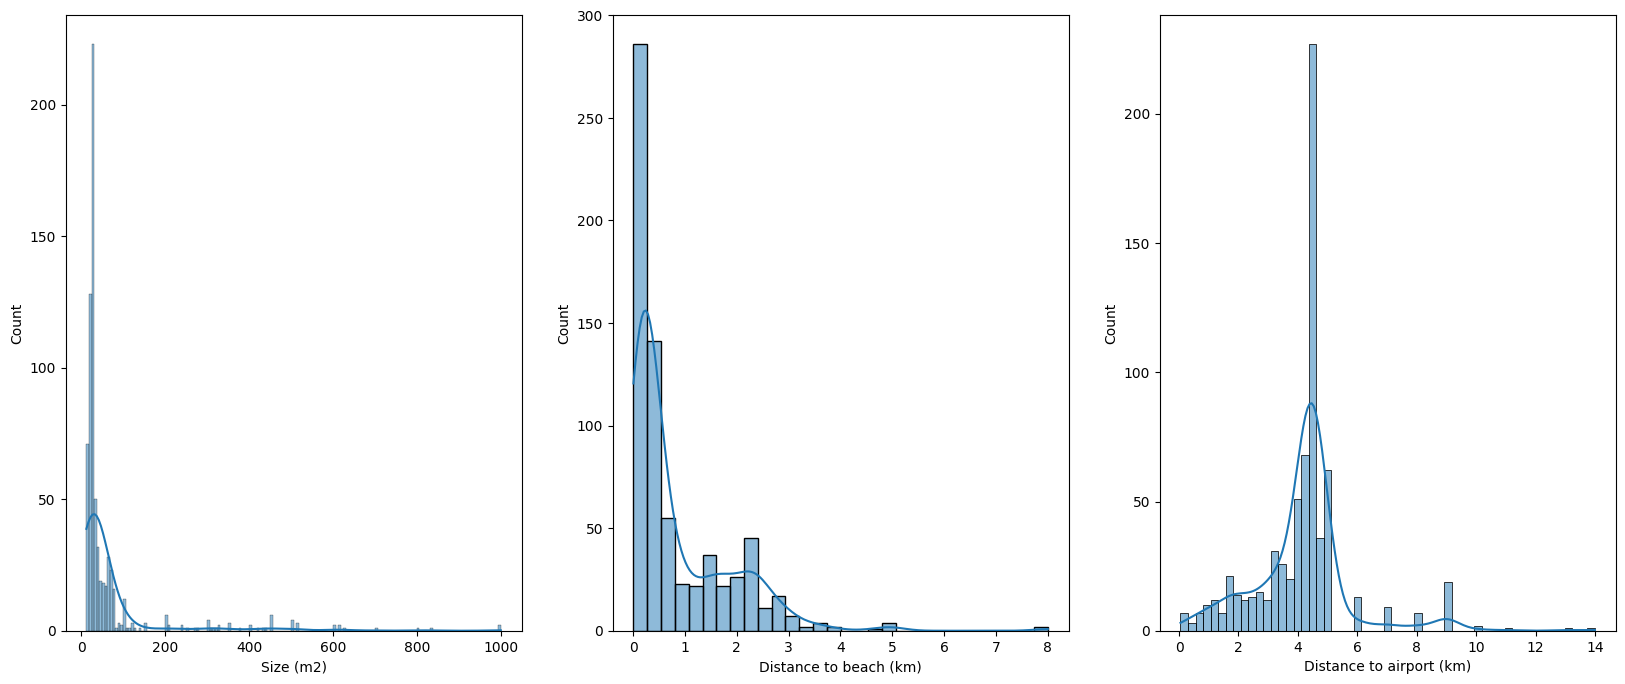

In [14]:
fig = plt.figure(figsize = (20, 8))
gs = gridspec.GridSpec(1, 3)

size = fig.add_subplot(gs[0, 0])
sns.histplot(data=X_train["Size"], ax = size, kde = True)
size.set_xlabel("Size (m2)")

beach = fig.add_subplot(gs[0, 1])
sns.histplot(data=X_train["Distance to beach"], ax = beach, kde = True)
beach.set_xlabel("Distance to beach (km)")

airport = fig.add_subplot(gs[0, 2])
sns.histplot(data=X_train["Distance to airport"], ax = airport, kde = True)
airport.set_xlabel("Distance to airport (km)")

### Thực hiện Log transformation để đưa dữ liệu về phân phối chuẩn và Robust scaling vì dữ liệu có nhiều outliers

In [15]:
def scale_data(x):
    x = np.array(x)
    x = np.reshape(x, (len(x), 1))
    scaler = RobustScaler(quantile_range=(15,85))
    x = scaler.fit_transform(x)
    return x


def transform(x):
    x = np.array(x)
    x = np.log(x)
    return x

### Thực hiện scale trên các biến numerical

In [16]:
features = ["Size", "Distance to beach", "Distance to airport"]
for feature in features:
    X_train[feature] = scale_data(transform(X_train[[feature]]))
    X_val[feature] = scale_data(transform(X_val[feature]))

Text(0.5, 0, 'Distance to airport (km)')

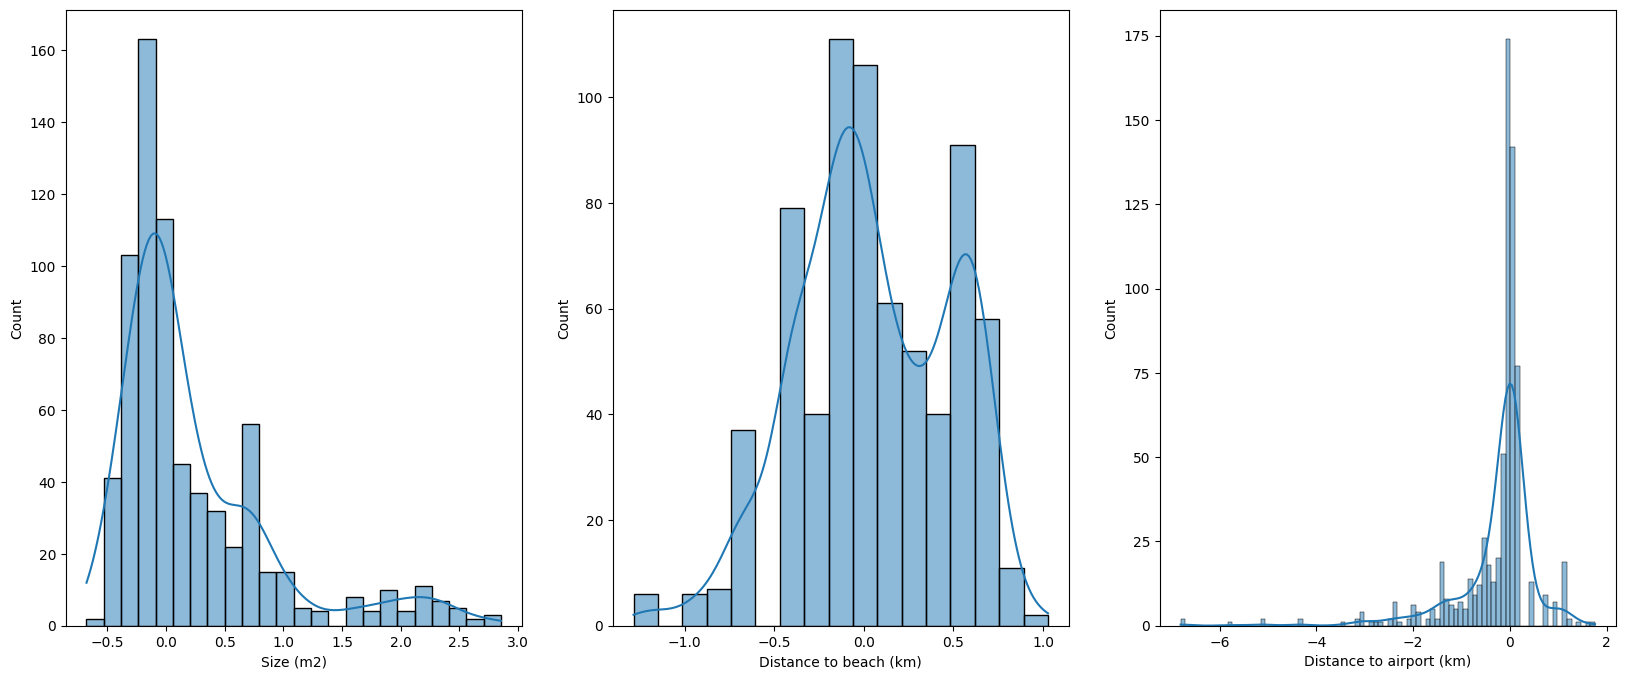

In [17]:
fig = plt.figure(figsize = (20, 8))
gs = gridspec.GridSpec(1, 3)

size = fig.add_subplot(gs[0, 0])
sns.histplot(data=X_train["Size"], ax = size, kde = True)
size.set_xlabel("Size (m2)")

beach = fig.add_subplot(gs[0, 1])
sns.histplot(data=X_train["Distance to beach"], ax = beach, kde = True)
beach.set_xlabel("Distance to beach (km)")

airport = fig.add_subplot(gs[0, 2])
sns.histplot(data=X_train["Distance to airport"], ax = airport, kde = True)
airport.set_xlabel("Distance to airport (km)")

## Xây dựng các class mô hình cho việc dự đoán và trình bày kết quả

In [18]:
class Model:
    def __init__(self):
        pass

    def predict(self, X_val):
        self.y_pred = self.model.predict(X_val)
        return self.y_pred
    
    
    # dùng để đánh giá mô hình trên metrics thông qua 4 metrics: MAE, RMSE, MAPE, R2 score
    def evaluate(self, y_true):
        self.score_mae = mean_absolute_error(y_true, self.y_pred)
        self.score_rmse = math.sqrt(mean_squared_error(y_true, self.y_pred))
        self.score_mape = mean_absolute_percentage_error(y_true, self.y_pred)
        self.r2 = r2_score(y_true, self.y_pred)
        
        print(Fore.GREEN + 'MAE: {}'.format(self.score_mae))
        print(Fore.GREEN + 'RMSE: {}'.format(self.score_rmse))
        print(Fore.GREEN + 'MAPE: {}'.format(self.score_mape))
        print(Fore.GREEN + 'R2: {}'.format(self.r2))
        
        return self.score_mae, self.score_rmse, self.score_mape, self.r2


    def plot_yy(self, width, height, y_pred, y_val):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)
        plt.scatter(y_val, y_pred, color='red')
        plt.plot(y_val, y_val)
        plt.grid()
        plt.xlabel('Actual price (Thousand VND)')
        plt.ylabel('Predicted price (Thousand VND)')
        plt.title('Scatter plot between actual y and predicted y')
        plt.show()
        
        
        
        
class ModelLinearRegression(Model):
    def __init__(self, regular = False):
        self.regular = regular
    def train(self, X_train, y_train):
        if not self.regular:
            self.model = LinearRegression()
        else:
            self.model = Ridge(alpha = 0.2)
        self.model.fit(X_train, y_train)
        

class ModelRandomForest(Model):
    def __init__(self, model, search=False):
        self.model = model
        self.search = search
        self.params = {
                        'n_estimators': [100, 200, 300],
                        'max_depth': [None, 10, 20],
                        'min_samples_split': [1, 2, 4],
                        'min_samples_leaf': [1, 2, 4],
                        'max_features': [None, 1, 2],
                        'bootstrap': [True, False]
                    }
    def train(self, X_train, y_train):
        if not self.search:
            self.model.fit(X_train, y_train)
        else:
            grid_search = GridSearchCV(estimator=self.model, param_grid=self.params, cv=5, n_jobs=-1, verbose=3, scoring="r2")
            grid_search.fit(X_train, y_train)
            self.params = grid_search.best_params_
            self.model = RandomForestRegressor(**self.params)
            self.model.fit(X_train, y_train)
            print(grid_search.scorer_)

### Kết quả của Linear Regression

MAE: 905.1692536476685
RMSE: 1262.1228858091085
MAPE: 1.1172655885672282
R2: 0.697486087364773


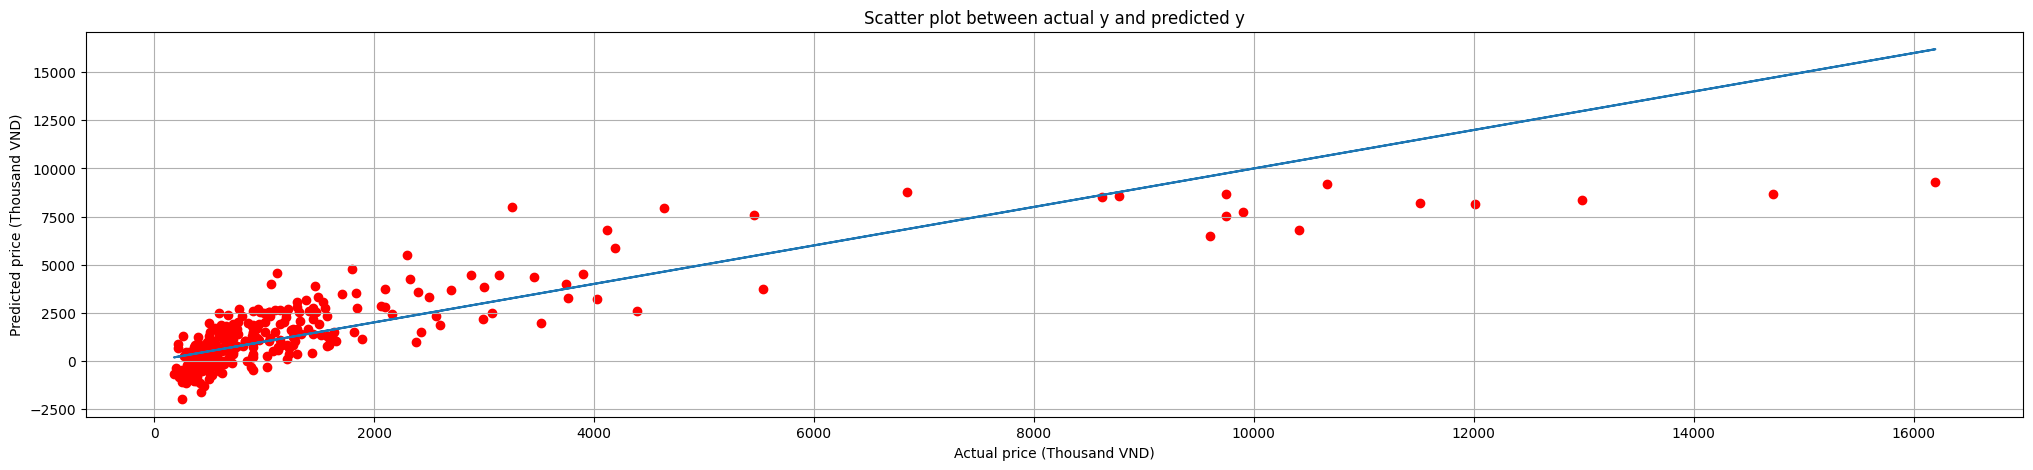

In [19]:
linear_reg = ModelLinearRegression()
linear_reg.train(X_train, y_train)
linear_y_pred = linear_reg.predict(X_val)
linear_score_mae, linear_score_rmse, linear_score_mape, linear_r2 = linear_reg.evaluate(y_val)
linear_reg.plot_yy(25, 5, linear_y_pred, y_val)

In [20]:
print(linear_reg.model.score(X_train, y_train))
print(linear_reg.model.score(X_val, y_val))

0.62493792862945
0.697486087364773


- MAPE cao: kết quả dự đoán còn lệch nhiều so với kết quả thực, đặc biệt là ở các mẫu có Price cao (đa số là thấp hơn giá trị thực)
- Mô hình cho ra kết quả khá tốt với phân khúc khách sạn giá vừa và thấp (~2 triệu đồng)

### Kết quả của Random Forest

MAE: 439.8734902098997
RMSE: 834.2978684847968
MAPE: 0.3686336190959332
R2: 0.8678143420176245


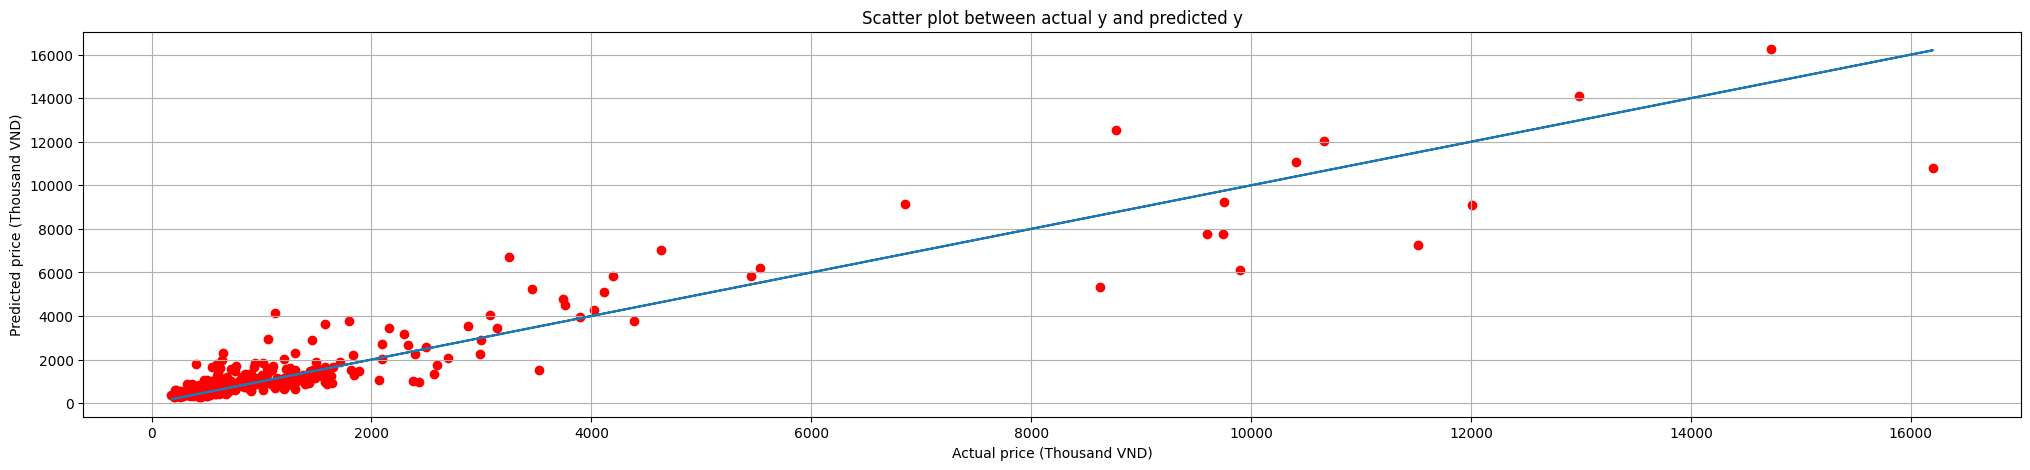

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [21]:
rdf = ModelRandomForest(model = RandomForestRegressor())
rdf.train(X_train, y_train)
rdf_y_pred = rdf.predict(X_val)
rdf_score_mae, rdf_score_rmse, rdf_score_mape, rdf_r2 = rdf.evaluate(y_val)
rdf.plot_yy(25, 5, rdf_y_pred, y_val)
print(rdf.model.get_params())

In [22]:
print(rdf.model.score(X_train, y_train))
print(rdf.model.score(X_val, y_val))

0.9604916886800523
0.8678143420176245


- Random Forest nhìn chung cho dự đoán tốt hơn

### Thực hiện cross-validation

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


make_scorer(r2_score, response_method='predict')
MAE: 434.70412184972633
RMSE: 862.4080809990505
MAPE: 0.3539255346101606
R2: 0.8587567494594546


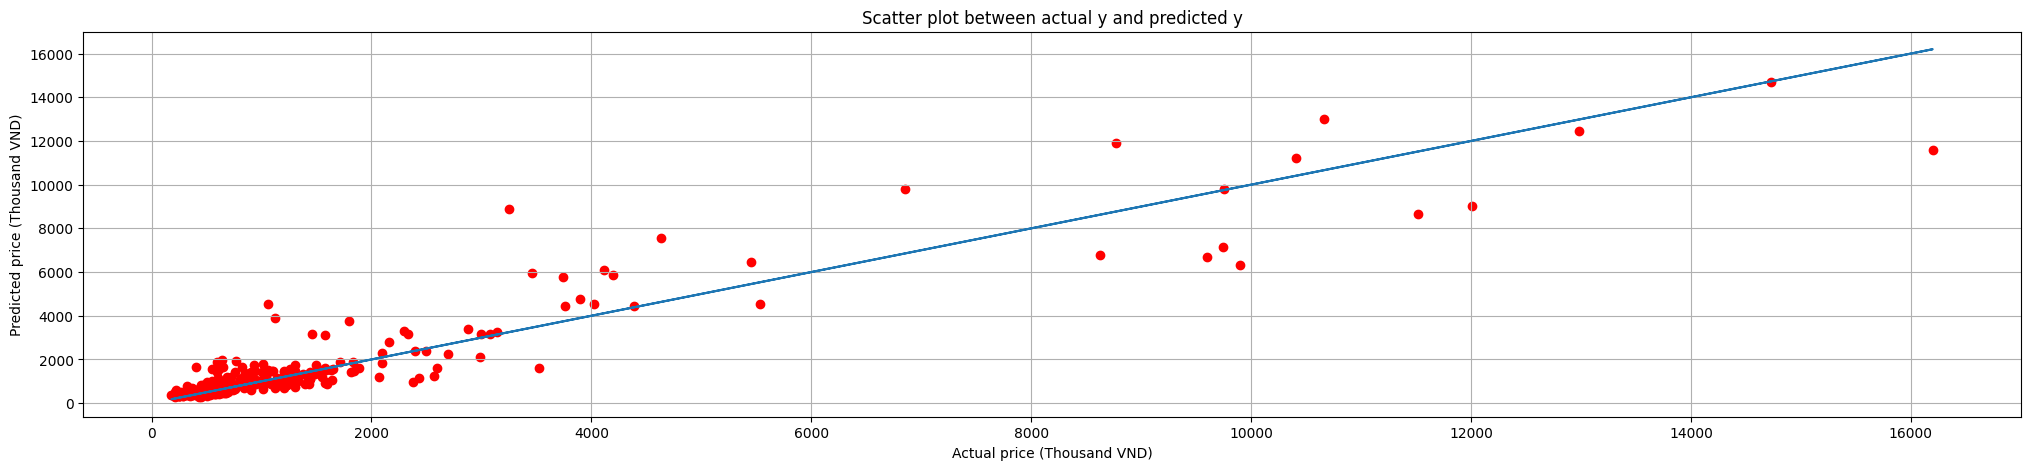

{'bootstrap': True, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}


In [23]:
rdf_xg = ModelRandomForest(model = RandomForestRegressor(), search = True)
rdf_xg.train(X_train, y_train)
rdf_xg_y_pred = rdf_xg.predict(X_val)
rdf_score_mae, rdf_score_rmse, rdf_score_mape, rdf_r2 = rdf_xg.evaluate(y_val)
rdf_xg.plot_yy(25, 5, rdf_xg_y_pred, y_val)
print(rdf_xg.params)

In [24]:
print(rdf_xg.model.score(X_train, y_train))
print(rdf_xg.model.score(X_val, y_val))

0.8539948148820773
0.8587567494594546


## Triển khai mô hình trên Test data

### Xử lý biến Price: Xóa VND, chia 1000

In [25]:
def convert(data):
    return int(data.split()[1].replace(".",""))

def scale(data):
    return round(data/1000)

### Load data test

In [26]:
data_test = pd.read_csv("../raw data/raw_data_test.csv", index_col=0)
data_test["Price"] = data_test["Price"].apply(lambda x: scale(convert(x)))

### Thực hiện feature engineering trên data test

In [27]:
X_test = data.drop(["Price"] , axis=1)
X_test = create_new_feature(X_test)
X_test = X_test[selected_features]
y_test = data["Price"]
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

### Chuẩn hóa các biến số thực

In [28]:
features = ["Size", "Distance to beach", "Distance to airport"]
for fea in features:
    X_test[fea] = scale_data(transform(X_test[fea]))

In [29]:
X_test.describe()

,Size,Distance to beach,Distance to airport,Pool,Bar,Facilities,Ratio
count,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000
mean,0.237679,0.048673,-0.256514,0.492582,0.376855,4.311573,0.731443
std,0.659670,0.425740,0.896728,0.500192,0.484838,1.669426,5.427727
min,-0.676343,-1.284938,-7.188087,0.000000,0.000000,0.000000,0.001400
25%,-0.192504,-0.278302,-0.306870,0.000000,0.000000,3.000000,0.034091
50%,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.076087
75%,0.462832,0.443170,0.067977,1.000000,1.000000,6.000000,0.405882
max,2.854132,1.027834,1.770004,1.000000,1.000000,8.000000,122.500000


### Kết quả thực thi mô hình

### Linear Regression

MAE: 967.5387241833456
RMSE: 1560.8730500916317
MAPE: 1.0769222477697478
R2: 0.6409912059430725


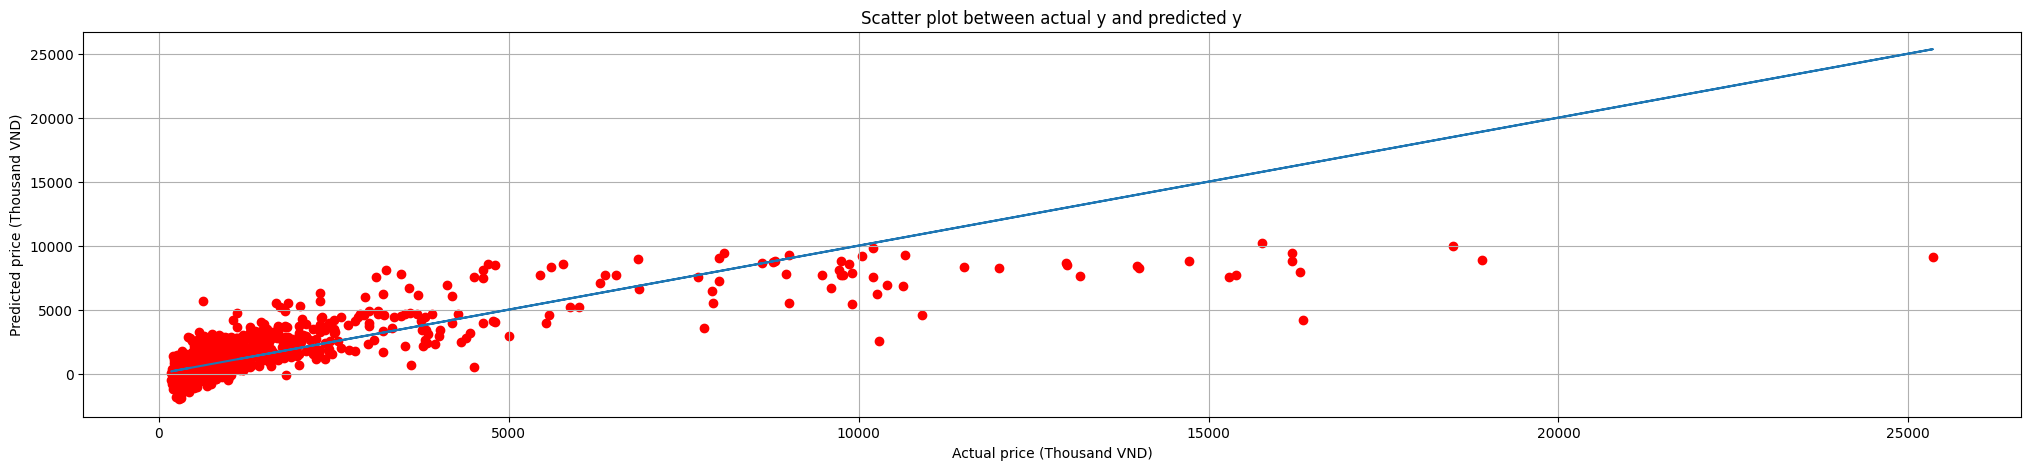

In [30]:
linear_y_pred = linear_reg.predict(X_test)
linear_score_mae, linear_score_rmse, linear_score_mape, linear_r2 = linear_reg.evaluate(y_test)
linear_reg.plot_yy(25, 5, linear_y_pred, y_test)

### Random Forest

MAE: 302.8744204229664
RMSE: 663.5855852808696
MAPE: 0.23723789488554128
R2: 0.9351120864843867


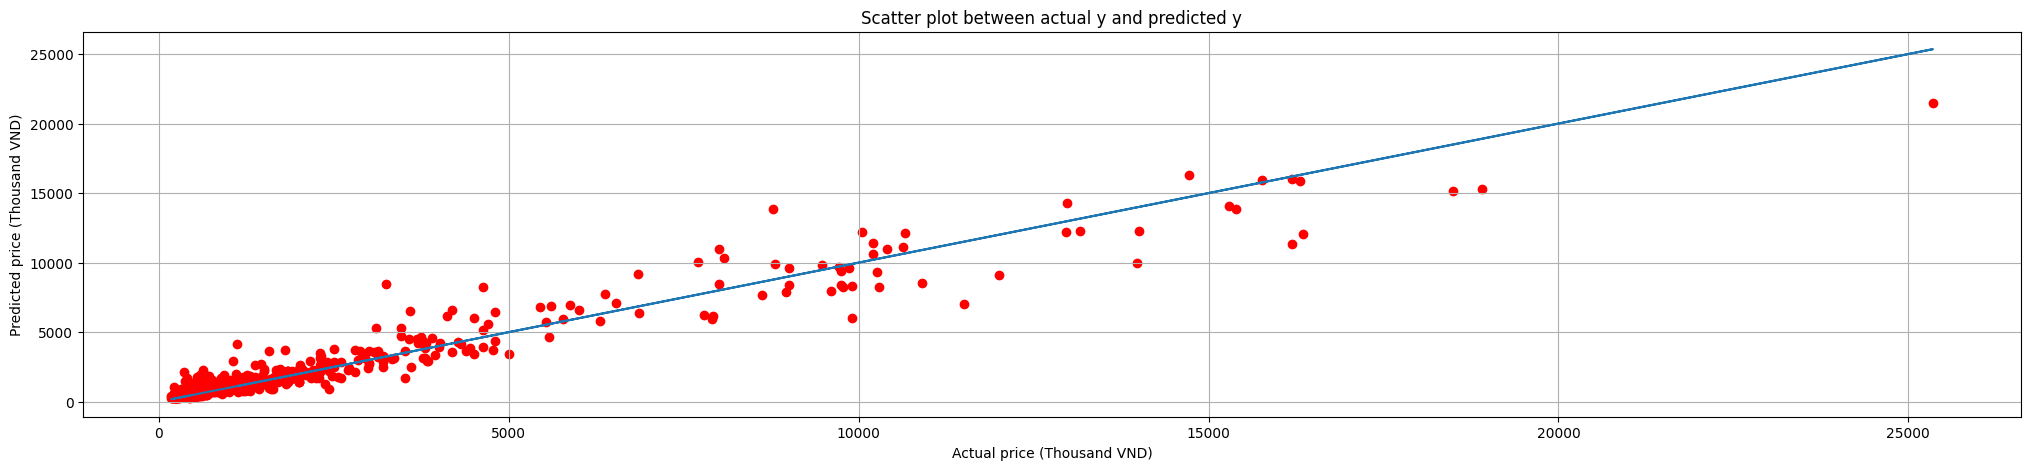

In [31]:
rdf_y_pred = rdf.predict(X_test)
rdf_score_mae, rdf_score_rmse, rdf_score_mape, rdf_r2 = rdf.evaluate(y_test)
rdf.plot_yy(25, 5, rdf_y_pred, y_test)